In [44]:
import json
import os
import sys
import importlib
from datetime import datetime
from pathlib import Path
from pprint import pprint

import requests


# Setup environment
if 'google.colab' in sys.modules:
    if not Path('rl-attention').exists():
        !git clone --quiet https://github.com/Pastafarianist/rl-attention.git
    else:
        %cd rl-attention/
        !git pull origin master
        %cd ..
        
    if 'rl-attention' not in sys.path:
        sys.path.append('rl-attention')
        
    config_path = Path('rl-attention/config.json')
else:
    config_path = Path('config.json')

# Read config
with config_path.open() as fp:
    cfg = json.load(fp)
    print('Original config:')
    pprint(cfg)

# Change config here
custom_cfg = {
    
}

# Update config
if custom_cfg:
    cfg.update(custom_cfg)
    print()
    print('Modified config:')
    pprint(cfg)

# Generate run ID
if 'run_ts' not in globals():
    run_ts = datetime.now().isoformat(sep='_', timespec='milliseconds').replace(':', '-')
run_name = '{env_name},{algo},{network},{train_seed},{run_ts}'.format(run_ts=run_ts, **cfg)
print('Run ID is {}'.format(run_name))

from bootstrap import setup_environment
run_dir = setup_environment(
    run_name=run_name,
    ssh_keys=[
        key
        for username in ['Pastafarianist', 'HoagyC', 'fabiansteuer', 'skosch', 'RerRayne']
        for key in requests.get('https://github.com/{}.keys'.format(username)).text.split('\n')
        if key
    ]
)

# Setup legacy logging from baselines (useful for comparisons)
log_dir = run_dir / cfg['log_dir']
from stable_baselines.logger import configure
configure(
    folder=str(log_dir / 'old'),
    format_strs=['log', 'csv', 'tensorboard']
)

/
Path exists
/rl-attention
total 72
18219681 4 drwxr-xr-x 4 root root 4096 Apr 30 09:10 .
 7995394 4 drwxr-xr-x 1 root root 4096 Apr 30 09:10 ..
18219727 4 -rw-r--r-- 1 root root 4006 Apr 30 09:10 bootstrap.py
18219728 8 -rw-r--r-- 1 root root 6786 Apr 30 09:10 colab.ipynb
18219729 4 -rw-r--r-- 1 root root  295 Apr 30 09:10 config.json
18219682 4 drwxr-xr-x 8 root root 4096 Apr 30 09:11 .git
18219710 4 -rw-r--r-- 1 root root 1216 Apr 30 09:10 .gitignore
18219725 4 -rw-r--r-- 1 root root 1057 Apr 30 09:10 LICENSE
18219730 4 -rw-r--r-- 1 root root  988 Apr 30 09:10 losses.py
18219731 4 -rw-r--r-- 1 root root 2705 Apr 30 09:10 main.py
18219732 8 -rw-r--r-- 1 root root 4655 Apr 30 09:10 models.py
18219726 4 -rw-r--r-- 1 root root 1455 Apr 30 09:10 README.md
18219733 4 -rw-r--r-- 1 root root   42 Apr 30 09:10 requirements.txt
18219734 4 -rw-r--r-- 1 root root 3268 Apr 30 09:10 saliency_renderer.py
18219735 4 drwxr-xr-x 2 root root 4096 Apr 30 09:10 saved_models
18219737 4 -rw-r--r-- 1 root

In [0]:
import gym
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

import stable_baselines
importlib.reload(stable_baselines)
from stable_baselines import PPO2
from stable_baselines.common import set_global_seeds
from stable_baselines.common.cmd_util import make_atari_env
from stable_baselines.common.vec_env import VecFrameStack, VecNormalize

from tqdm import tqdm_notebook

# Load and re-load modules just to make sure they're up to date
import models; importlib.reload(models)
import losses; importlib.reload(losses)
import saliency_renderer; importlib.reload(saliency_renderer)

from models import get_network_builder
from losses import get_loss
from saliency_renderer import SaliencyRenderer

In [0]:
class Callback(object):
    def __init__(self, display_frames=False, display_saliency_map=False):
        self.display_frames = display_frames
        self.display_saliency_map = display_saliency_map
        self.pbar = None
    
    def __call__(self, _locals, _globals):
        if self.pbar is None:
            self.pbar = tqdm_notebook(total=_locals['nupdates'] * _locals['self'].n_batch)
        
        self.pbar.update(_locals['self'].n_batch)
        
        self.session, self.graph, self.env = _locals['self'].sess, _locals['self'].graph, _locals['self'].env
        input_values = self.env.stackedobs
        input_tensor = self.graph.get_tensor_by_name("train_model/input/Ob:0")
        input_cast_tensor = self.graph.get_tensor_by_name("train_model/input/Cast:0")
        c1_activations = self.graph.get_tensor_by_name("train_model/model/Relu:0")
        c2_activations = self.graph.get_tensor_by_name("train_model/model/Relu_1:0")
        c3_activations = self.graph.get_tensor_by_name("train_model/model/Relu_2:0")
        a1_activations = self.graph.get_tensor_by_name("train_model/model/Elu:0")
        a2_activations = self.graph.get_tensor_by_name("train_model/model/a2/add:0")
        
        if _locals['update'] == _locals['nupdates']:
            self.pbar.close()
            self.pbar = None
        
        if _locals['update'] % 10 == 1 or _locals['update'] == _locals['nupdates']:
            if self.display_frames:
                plt.grid(None)
                plt.imshow(_locals["self"].env.render(mode='rgb_array'))
                plt.show()
                
            if self.display_saliency_map:
                sr = SaliencyRenderer(_locals)
                smap = sr.get_basic_input_saliency_map(input_tensor, input_values, input_cast_tensor, a2_activations, 
                                                       selection_method='SUM', n_gradient_samples=10, gradient_sigma_spread=0.15)
                plt.imshow(smap[0, :, :, 0])
                plt.colorbar()
                plt.show()

            
            # Save current model
            _locals['self'].save(str(run_dir / 'model.pkl'))

        return True

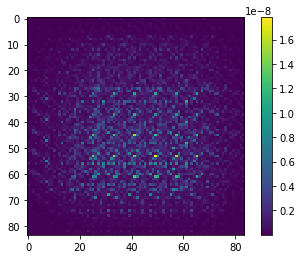

Process ForkProcess-105:
Process ForkProcess-109:
Process ForkProcess-111:
Process ForkProcess-108:
Process ForkProcess-110:
Process ForkProcess-107:
Process ForkProcess-106:
Process ForkProcess-112:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/pr

KeyboardInterrupt: ignored

In [58]:
# Dump entire configuration
with (run_dir / 'config.json').open('w') as fp:
    json.dump(cfg, fp, indent=2)

set_global_seeds(cfg['train_seed'])

env = make_atari_env(cfg['env_name'], num_env=8, seed=cfg['train_seed'])
env = VecFrameStack(env, n_stack=4) # stack 4 frames

# TODO: perhaps the below can be packaged up into a nice .py file
# with different types of training algorithms etc.

model_params_source = 'FRESH' # or: 'UPLOAD' or 'GDRIVE'

kwargs = {
    'verbose': 1,
    'learning_rate': lambda frac: 0.00025 * frac,
    'attn_loss': get_loss(cfg['attn_loss'])(),
    'attn_coef': cfg['attn_coef'],
    'policy_kwargs': {
        'cnn_extractor': get_network_builder(cfg['network'])
    },
    'tensorboard_log': str(log_dir / 'new'),
}

if model_params_source == 'FRESH':
    model = PPO2(cfg['policy_type'], env, **kwargs)
else:
    if model_params_source == 'UPLOAD':
        uploaded_files = files.upload()  # will save the file to the /content folder
        model_path = list(uploaded_files.keys())[0]
    elif model_params_source == 'GDRIVE':
        model_path = run_dir / 'model.pkl'
    else:
        raise ValueError("Source should be one of: FRESH, UPLOAD, GDRIVE")
        
    model = PPO2.load(model_path, env, **kwargs)

callback = Callback(display_saliency_map=True)
model.learn(total_timesteps=cfg['time_steps'], callback=callback, log_interval=cfg['log_interval'])